## > Task:-2 : AQI In Delhi
## > Batch : Jun-July
## > Domain : Data Science
## > Aim :Conduct an in-depth analysis of the Air Quality Index (AQI) in Delhi, addressing the specific environmental challenges faced by the city.


### Library nedded

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset=pd.read_csv("C:\\Users\\jaypa\\Downloads\\delhiaqi.csv")
dataset.head()

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2023-01-01 00:00:00,1655.58,1.66,39.41,5.90,17.88,169.29,194.64,5.83
1,2023-01-01 01:00:00,1869.20,6.82,42.16,1.99,22.17,182.84,211.08,7.66
2,2023-01-01 02:00:00,2510.07,27.72,43.87,0.02,30.04,220.25,260.68,11.40
3,2023-01-01 03:00:00,3150.94,55.43,44.55,0.85,35.76,252.90,304.12,13.55
4,2023-01-01 04:00:00,3471.37,68.84,45.24,5.45,39.10,266.36,322.80,14.19


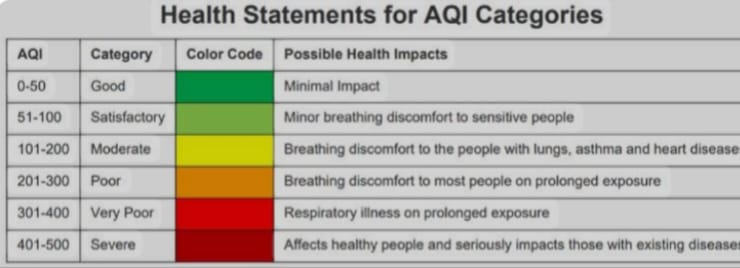

In [3]:
from IPython.display import Image
Image(filename="C:\\Users\\jaypa\\Downloads\\Air Quality Breakpoints.jpeg")

## Define Breakpoints

In [4]:
# In each tuple, First two represent concentration and last two represent Quality Index

co_breakpoints=[
    (0,1,0,50),(1.01,2,51,1000),(2.01,10,101,200),
    (10.01,17,201,300),(17.01,34,301,400),(34.01,999999,401,500),
]
no2_breakpoints=[
    (0,40,0,50),(41,80,51,100),(81,180,101,200),
    (181,280,201,300),(281,400,301,400),(401,999999,401,500),
]
no_breakpoints=no2_breakpoints

o3_breakpoints=[
    (0,50,0,50),(51,100,51,100),(101,168,101,200),
    (169,208,201,300),(209,748,301,400),(749,999999,401,500),
]
so2_breakpoints=[
    (0,40,0,50),(41,80,51,100),(81,380,101,200),
    (381,800,201,300),(801,1600,301,400),(1601,999999,401,500),
]
pm25_breakpoints=[
    (0,30,0,50),(31,60,51,100),(61,90,101,200),
    (91,120,201,300),(121,250,301,400),(251,999999,401,500),
]
pm10_breakpoints=[
    (0,50,0,50),(51,100,51,100),(101,250,101,200),
    (251,350,201,300),(351,430,301,400),(431,999999,401,500),
]
nh3_breakpoints=[
    (0,200,0,50),(201,400,51,100),(401,800,101,200),
    (801,1200,201,300),(1201,1800,301,400),(1801,999999,401,500),
]

## Calculate Sub Indices

In [5]:
def calculate_sub_index(concentration,breakpoints):
    for (low_conc,high_conc,low_index,high_index) in breakpoints:
        if low_conc <= concentration <= high_conc:
            return low_index+ (high_index-low_index) / (high_conc-low_conc) * (concentration - low_conc)
    return 500


In [6]:
ugm3_to_mgm3=0.01
def calculate_aqi(row):
    row["pm_2_5_sub_index"] = calculate_sub_index(row["pm2_5"],pm25_breakpoints)
    row["pm_10_sub_index"] = calculate_sub_index(row["pm10"],pm10_breakpoints)
    row["no2_sub_index"] = calculate_sub_index(row["no2"],no2_breakpoints)
    row["o3_sub_index"] = calculate_sub_index(row["o3"],o3_breakpoints)
    row["co_sub_index"] = calculate_sub_index(row["co"]*ugm3_to_mgm3,co_breakpoints) # convert from ug/m3 to mg/m3
    row["so2_sub_index"] = calculate_sub_index(row["so2"],so2_breakpoints)
    row["nh3_sub_index"] = calculate_sub_index(row["nh3"],nh3_breakpoints)
    row["no_sub_index"] = calculate_sub_index(row["no"],no_breakpoints)

    aqi=max(row["pm_2_5_sub_index"],row["pm_10_sub_index"],row["no2_sub_index"] ,
           row["o3_sub_index"],row["co_sub_index"],row["co_sub_index"],  row["so2_sub_index"],
           row["nh3_sub_index"], row["no_sub_index"])
    return aqi

In [7]:
dataset["AQI"]=dataset.apply(calculate_aqi,axis=1)
dataset[["date","AQI"]].head()

,date,AQI
0,2023-01-01 00:00:00,338.059767
1,2023-01-01 01:00:00,348.458605
2,2023-01-01 02:00:00,377.168605
3,2023-01-01 03:00:00,401.000188
4,2023-01-01 04:00:00,401.001521


## Define AQI Categories

In [8]:
aqi_categories={
    (0,50):"Good",
    (51,100):"Satisfactory",
    (101,200):"Moderately Polluted",
    (201,300):"Poor",
    (301,400):"Very Poor",
    (401,500):"Server"
}

## Categorize Data

In [9]:
def get_aqi_category(aqi):
    for (low_aqi,high_aqi), category in aqi_categories.items():
        if low_aqi<=aqi<=high_aqi:
            return category
    return "Server"

In [10]:
dataset["AQI_Category"]=dataset["AQI"].apply(get_aqi_category)
aqi_category_distribution=dataset["AQI_Category"].value_counts(normalize=True)*100
aqi_category_distribution

AQI_Category
Server                 67.557932
Very Poor              29.946524
Poor                    1.782531
Moderately Polluted     0.713012
Name: proportion, dtype: float64

## Hourly trends of AQI

In [11]:
dataset["date"]=pd.to_datetime(dataset["date"])
dataset["hour"]=dataset["date"].dt.hour
hourly_aqi=dataset.groupby("hour")["AQI"].mean()

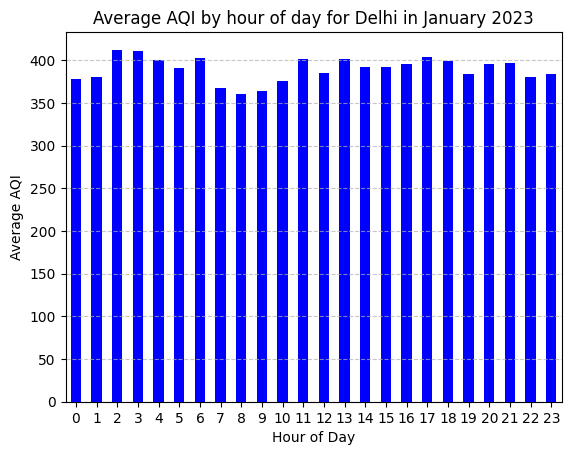

In [12]:
hourly_aqi.plot(kind="bar",color="blue")
plt.title("Average AQI by hour of day for Delhi in January 2023")
plt.xlabel("Hour of Day")
plt.ylabel("Average AQI")
plt.xticks(rotation=0)
plt.grid(axis="y",linestyle="--",alpha=0.7)
plt.show()

In [13]:
day_hours=(6,18)
night_hours=(18,6)

daytime_data=dataset[(dataset["hour"] >= day_hours[0]) & (dataset["hour"] < day_hours[1])]
nighttime_data=dataset[(dataset["hour"] >= day_hours[0]) | (dataset["hour"] < day_hours[1])]

average_day_aqi=daytime_data["AQI"].mean()
average_night_aqi=daytime_data["AQI"].mean()

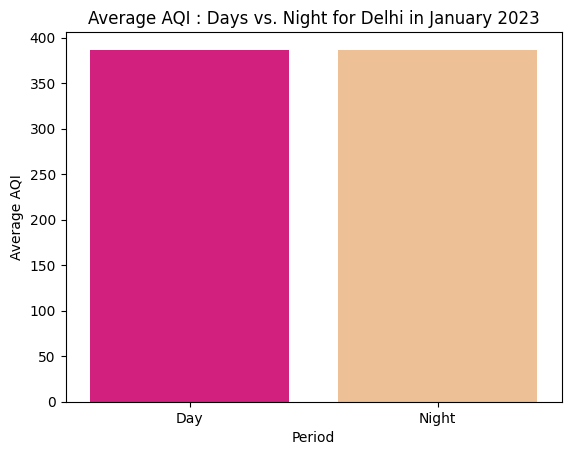

In [16]:
day_night_aqi_comparison=pd.DataFrame({
    "Period":["Day","Night"],
    "Average AQI":[average_day_aqi,average_night_aqi]
})

sns.barplot(x="Period",y="Average AQI",data=day_night_aqi_comparison,palette="Accent_r",hue="Period")
plt.title("Average AQI : Days vs. Night for Delhi in January 2023")
plt.ylabel("Average AQI")
plt.show()

## Exploring correlation between pollutants

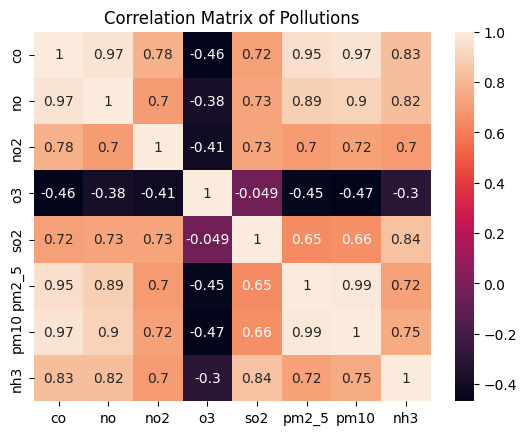

In [15]:
pollutants=["co","no","no2","o3","so2","pm2_5","pm10","nh3"]
correlation_matrix=dataset[pollutants].corr()

plt.title("Correlation Matrix of Pollutions")
sns.heatmap(correlation_matrix,annot=True)
plt.show()

# Analysis 

### 1. Air Quality Levels:
### The analysis revealed that 97.33% of the time the air quality was categorized es either "very poor" or "server"
### 2. Hourly Trends:
### The AQI was slightly higher at night (average AQI of 393.01) compared to the day (average AQI of 386.26)
### 3. Daily Extremes:
### The hightest daily AQI was 421.63 and the lowest was 330.37
